<a href="https://colab.research.google.com/github/juln94/BUS5001-Resources/blob/main/BUS5PR1_Predicting_Loan_Default_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Loan Default Risk

This project aims to predict default risk of customers.

We will train dataset with three machine learning (ML) models (logistic regression, random forest and XGBoost) and evaluate to choose the best performed model based on f1-score (for correctly predicting class 1, i.e. default) to predict an unseen test dataset.

## Import necessary packages

In [3]:
# Load necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix,
    roc_curve, auc
)

from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/Colab Notebooks/BUS5PR1/Datasets-20250527

/content/drive/MyDrive/Colab Notebooks/BUS5PR1/Datasets-20250527


##Load and explore datasets

In [6]:
# Dataset Overview (supports optional label)
def data_overview(df, label_col_name=None):
  print("\nDataset Overview")
  print("\nSamples from head:\n", df.head())
  print("\nSamples from tail:\n", df.tail())
  print("\nStats of numeric columns:\n", df.describe())
  print("\nData types:\n")
  print(df.info())
  print("\nDimensions (rows, columns):\n", df.shape)
  for col in df.columns:
    print("\nUnique values in", col)
    print(df[col].unique())

  if label_col_name and label_col_name in df.columns:
    print("\nNumber of records by label:")
    print(df[label_col_name].value_counts(dropna=False))


In [7]:
def count_missing_val(df, label_col_name=None):
    print("\n✅ Missing Value Summary")
    # Replace infinite values with NaN
    df = df.replace([np.inf, -np.inf], np.nan)

    # Count missing values which belong to bad label
    is_bad = []
    for col in df.columns:
        if label_col_name and label_col_name in df.columns:
            is_bad_val = (
                ((col != label_col_name) & (df[col].isnull())) &
                (df[label_col_name] == 1)
            ).sum()
        else:
            is_bad_val = np.nan  # Not applicable if no label column
        is_bad.append(is_bad_val)

    # Identify number of missing values in each column
    missing_value_counts = pd.DataFrame({
        'num_missing_vals': df.isnull().sum(),
        '%_missing': df.isnull().sum() / len(df) * 100,
        'is_bad_count': is_bad
    })
    print(missing_value_counts.sort_values('num_missing_vals', ascending=False))

    # Count total missing values per row
    missing_counts = df.isnull().sum(axis=1)
    print("\nTotal row with missing value(s):", (missing_counts >= 1).sum())
    print("Rows with 1 missing value:", (missing_counts == 1).sum())
    print("Rows with >=2 missing values:", (missing_counts >= 2).sum())

In [8]:
# Duplicate Check
def check_duplicates(df):
    print("\n✅ Duplicate Check")
    num_duplicates = df.duplicated().sum()
    print("Number of duplicate rows:", num_duplicates)

In [9]:
# Outlier Detection (IQR method)
def detect_outliers(df, numeric_columns):
    print("\n✅ Outlier Detection (IQR Method)")
    outlier_summary = {}
    for col in numeric_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower) | (df[col] > upper)]
        outlier_summary[col] = len(outliers)
        print(f"{col}: {len(outliers)} outliers")
    return outlier_summary

In [10]:
# Load the 2 datasets
train_df = pd.read_csv('data_train.csv', header=0)
test_df = pd.read_csv('data_test.csv', header=0)

### Examine train dataset

In [11]:
# Train dataset overview
data_overview(train_df, label_col_name="Risk_Flag")


Dataset Overview

Samples from head:
       Id   Income  Age  Experience Married/Single House_Ownership  \
0  50000  3078173   59          12         single          rented   
1  50001   962072   25          14         single          rented   
2  50002  6272029   49          12         single          rented   
3  50003  3315074   72          14         single          rented   
4  50004  9078449   79          10         single           owned   

  Car_Ownership          Profession         CITY           STATE  \
0           yes           Librarian     Parbhani     Maharashtra   
1           yes          Consultant     Phagwara          Punjab   
2            no             Drafter        Sagar  Madhya_Pradesh   
3            no  Software_Developer  Thoothukudi      Tamil_Nadu   
4           yes            Designer      Danapur           Bihar   

   CURRENT_JOB_YRS  CURRENT_HOUSE_YRS  Risk_Flag  
0                9                 10          1  
1                4                 

The train dataset has 232,000 records with 13 columns in which one column is unique identifier "Id" and 1 label (target) column "Risk_Flag".

In [12]:
# Missing value summary of train dataset
count_missing_val(train_df,'Risk_Flag')


✅ Missing Value Summary
                   num_missing_vals  %_missing  is_bad_count
Id                                0        0.0             0
Income                            0        0.0             0
Age                               0        0.0             0
Experience                        0        0.0             0
Married/Single                    0        0.0             0
House_Ownership                   0        0.0             0
Car_Ownership                     0        0.0             0
Profession                        0        0.0             0
CITY                              0        0.0             0
STATE                             0        0.0             0
CURRENT_JOB_YRS                   0        0.0             0
CURRENT_HOUSE_YRS                 0        0.0             0
Risk_Flag                         0        0.0             0

Total row with missing value(s): 0
Rows with 1 missing value: 0
Rows with >=2 missing values: 0


In [13]:
check_duplicates(train_df)


✅ Duplicate Check
Number of duplicate rows: 0


In [14]:
# Define a variable for numerical columns used in outlier detection and potentially for scaling
numeric_cols = ['Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']
train_outliers = detect_outliers(train_df, numeric_cols)


✅ Outlier Detection (IQR Method)
Income: 0 outliers
Age: 0 outliers
Experience: 0 outliers
CURRENT_JOB_YRS: 0 outliers
CURRENT_HOUSE_YRS: 0 outliers


There is no missing value, duplicate or outlier found in the train dataset.

### Examine the test data

In [15]:
# Overview of test dataset
data_overview(test_df)


Dataset Overview

Samples from head:
       Id   Income  Age  Experience Married/Single House_Ownership  \
0  30000  4260981   47          18         single          rented   
1  30001  8529345   44           2         single          rented   
2  30002  7848654   55           9         single          rented   
3  30003  8491491   61          20         single          rented   
4  30004  1537266   78          13         single          rented   

  Car_Ownership                  Profession          CITY           STATE  \
0            no                  Politician      Hindupur  Andhra_Pradesh   
1            no  Computer_hardware_engineer  Narasaraopet  Andhra_Pradesh   
2            no          Software_Developer         Patna           Bihar   
3            no                    Comedian        Haldia     West_Bengal   
4            no                Web_designer    Coimbatore      Tamil_Nadu   

   CURRENT_JOB_YRS  CURRENT_HOUSE_YRS  
0                7                 13  
1  

In [16]:
# Missing values summary of test dataset
count_missing_val(test_df)


✅ Missing Value Summary
                   num_missing_vals  %_missing  is_bad_count
Id                                0        0.0           NaN
Income                            0        0.0           NaN
Age                               0        0.0           NaN
Experience                        0        0.0           NaN
Married/Single                    0        0.0           NaN
House_Ownership                   0        0.0           NaN
Car_Ownership                     0        0.0           NaN
Profession                        0        0.0           NaN
CITY                              0        0.0           NaN
STATE                             0        0.0           NaN
CURRENT_JOB_YRS                   0        0.0           NaN
CURRENT_HOUSE_YRS                 0        0.0           NaN

Total row with missing value(s): 0
Rows with 1 missing value: 0
Rows with >=2 missing values: 0


In [17]:
def plot_categorical_frequencies(df):
  """
  Plots bar plots for the frequency distribution of categorical columns
  in a pandas DataFrame.

  Args:
    df: The input pandas DataFrame.
  """
  categorical_cols = df.select_dtypes(include='object').columns # Or use include=['category', 'object'] if you have 'category' dtype
  num_plots = len(categorical_cols)
  if num_plots == 0:
    print("No categorical columns found in the DataFrame.")
    return

  # Determine grid size for subplots
  n_cols = 3  # You can adjust this number
  n_rows = (num_plots + n_cols - 1) // n_cols

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5))
  axes = axes.flatten() # Flatten the 2D array of axes for easier iteration

  for i, col in enumerate(categorical_cols):
    # Calculate value counts and plot using seaborn.countplot
    sns.countplot(data=df, y=col, ax=axes[i], order=df[col].value_counts().index)
    axes[i].set_title(f'Frequency of {col}')
    axes[i].set_xlabel('Frequency')
    axes[i].set_ylabel(col)

  # Hide any unused subplots
  for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

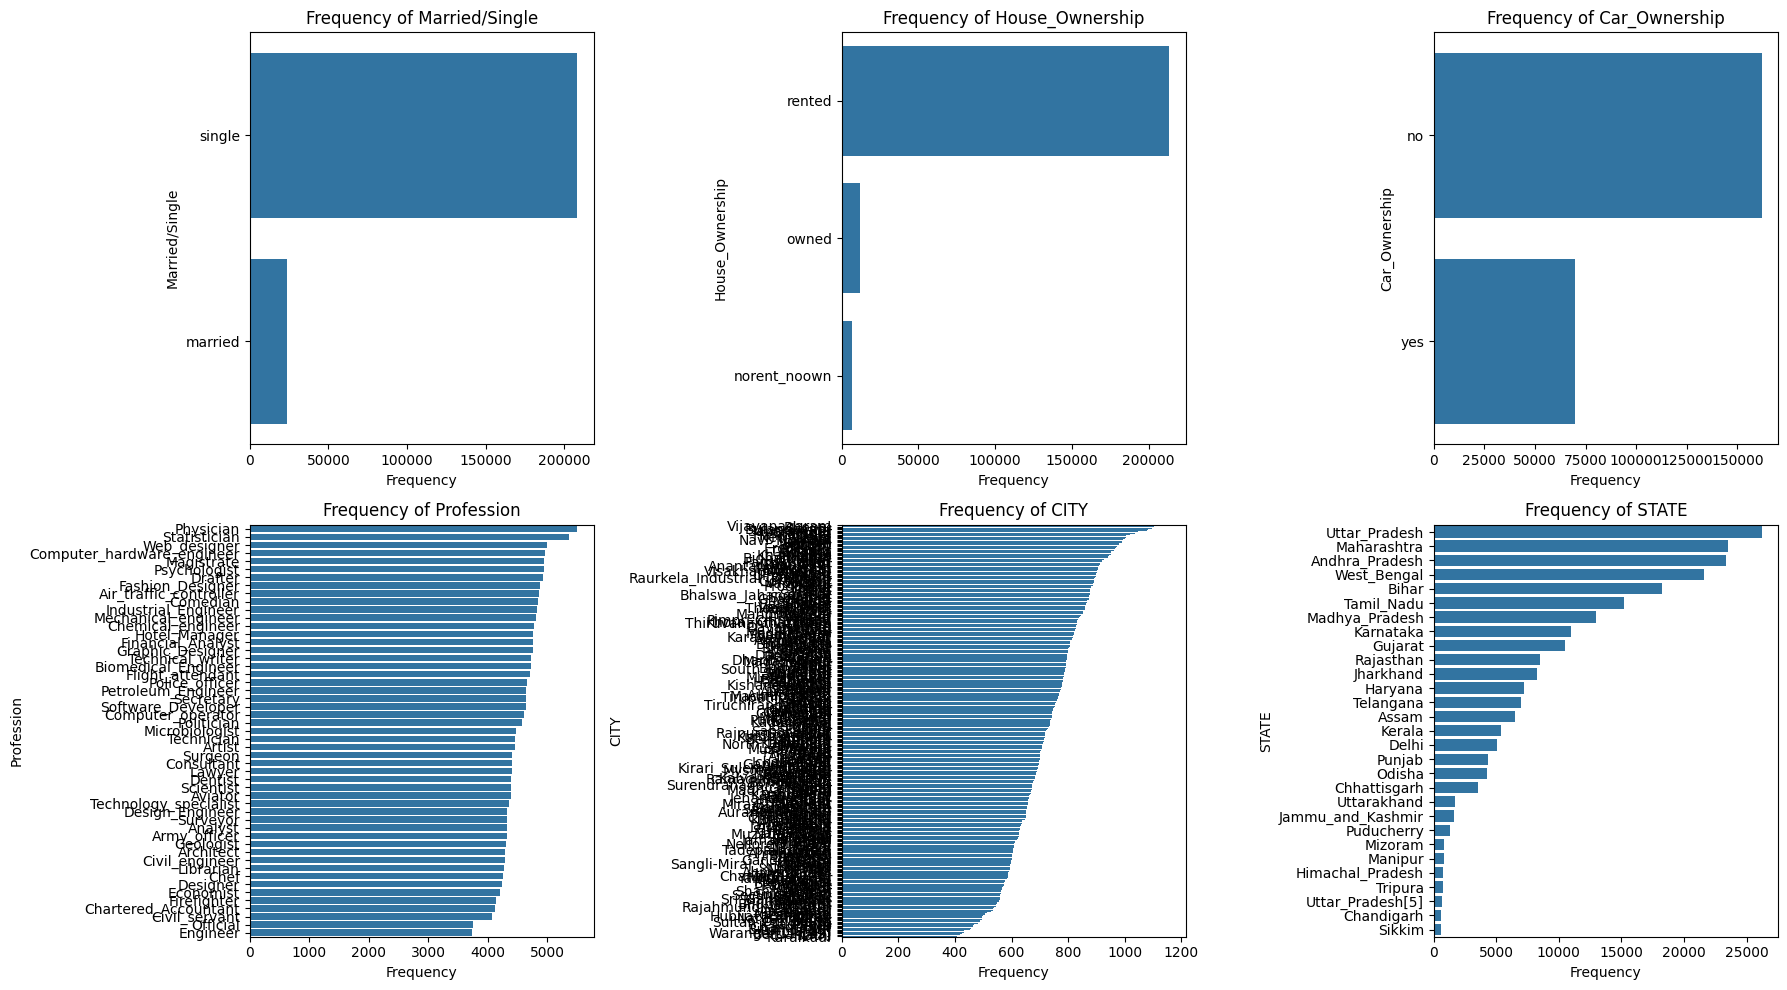

In [18]:
plot_categorical_frequencies(train_df)

In [19]:
# Define column groups
continuous_cols = ['Income']  # Too many unique values — use histogram
discrete_cols = ['Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']  # Use value_counts

# 1. Plot histogram for continuous features
def plot_histograms(df, cols):
    for col in cols:
        fig = px.histogram(df, x=col, nbins=50, title=f"Histogram of {col}")
        fig.show()

# 2. Plot bar charts (value_counts) for discrete features
def plot_value_counts(df, cols, rows=3, cols_per_row=2):
    fig = make_subplots(rows=rows, cols=cols_per_row, subplot_titles=cols)
    for i, col in enumerate(cols):
        row = i // cols_per_row + 1
        col_pos = i % cols_per_row + 1
        value_counts = df[col].value_counts().sort_index()
        fig.add_trace(
            go.Bar(x=value_counts.index.astype(str), y=value_counts.values, name=col),
            row=row, col=col_pos
        )
    fig.update_layout(
        height=400 * rows,
        width=1000,
        title_text="Value Counts per Column (Categorical Frequency)",
        showlegend=False
    )
    fig.show()

# Run all plots
plot_histograms(train_df, continuous_cols)
plot_value_counts(train_df, discrete_cols)


In [20]:
# Updated categorical column list
cat_cols = ['Risk_Flag', 'Married/Single',
                    'House_Ownership', 'Car_Ownership',
                    'Profession', 'CITY', 'STATE']

# Plot frequency bar charts for categorical variables (including Risk_Flag)
def plot_categorical_frequencies(df, cols, rows=4, cols_per_row=2):
    fig = make_subplots(rows=rows, cols=cols_per_row, subplot_titles=cols)

    for i, col in enumerate(cols):
        row = i // cols_per_row + 1
        col_pos = i % cols_per_row + 1
        value_counts = df[col].value_counts().sort_values(ascending=False).head(20)  # Top 20 only
        fig.add_trace(
            go.Bar(x=value_counts.index.astype(str), y=value_counts.values, name=col),
            row=row, col=col_pos
        )

    fig.update_layout(
        height=400 * rows,
        width=1100,
        title_text="Frequency of Categorical Variables (Top 20)",
        showlegend=False
    )
    fig.show()

# Plot the updated categorical frequency charts
plot_categorical_frequencies(train_df, cat_cols, rows=4, cols_per_row=2)


### Grouping Age and Income into several groups for exploration

In [21]:
train_df['Age_Group'] = pd.cut(train_df['Age'], bins=[20, 30, 40, 50, 60, 70, 80], right=False)
train_df['Income_Band'] = pd.cut(train_df['Income'], bins=[0, 1_000_000, 3_000_000, 5_000_000, 7_000_000, 10_000_000], right=False)


In [22]:
# Create age and income bins
train_df['Age_Group'] = pd.cut(train_df['Age'], bins=[20, 30, 40, 50, 60, 70, 80], right=False)
train_df['Income_Band'] = pd.cut(train_df['Income'], bins=[0, 2_000_000, 4_000_000, 6_000_000, 8_000_000, 10_000_000], right=False)

# Convert intervals to string for plotting
train_df['Age_Group_Str'] = train_df['Age_Group'].astype(str)
train_df['Income_Band_Str'] = train_df['Income_Band'].astype(str)

# Plot Age Group distribution
px.bar(
    train_df['Age_Group_Str'].value_counts().sort_index(),
    title="Age Group Distribution",
    labels={"index": "Age Group", "value": "Count"}
).show()

# Plot Income Band distribution
px.bar(
    train_df['Income_Band_Str'].value_counts().sort_index(),
    title="Income Band Distribution",
    labels={"index": "Income Band", "value": "Count"}
).show()


**Age:**

In general, customers span several age group evenly, even though there is a slightly higher frequency in age range from 40 to 70.

**Income:**

Customers span a wide range of income from 0 to 10M evenly.

In [23]:
def plot_categorical_percent_by_risk(df, cat_vars, target='Risk_Flag'):
    for var in cat_vars:
        # Group and calculate percentage within each category
        counts = df.groupby([var, target]).size().reset_index(name='count')
        counts['percent'] = counts.groupby(var)['count'].transform(lambda x: x / x.sum() * 100)
        counts['target_str'] = counts[target].astype(str)

        # Get sort order by Risk_Flag == 1 percentage (descending)
        sort_order = (
            counts[counts[target] == 1]
            .sort_values('percent', ascending=False)[var]
            .tolist()
        )

        # Enforce order of categories in plotting
        counts[var] = pd.Categorical(counts[var], categories=sort_order, ordered=True)

        # Sort the full DataFrame to reflect that order
        counts = counts.sort_values(by=var)

        # Plot
        fig = px.bar(
            counts,
            y=var,
            x='percent',
            color='target_str',
            orientation='h',
            text='percent',
            title=f'Percentage of Risk_Flag by {var} (Sorted by Risk=1 ↓)',
            labels={'percent': 'Percentage (%)', var: var, 'target_str': 'Risk Flag'}
        )

        fig.update_layout(
            barmode='stack',
            xaxis=dict(tickformat=".0f"),
            legend_title_text='Risk Flag'
        )
        fig.update_traces(texttemplate='%{text:.1f}%', textposition='inside')
        fig.show()


In [24]:
cat_vars = ['Married/Single', 'House_Ownership', 'Car_Ownership',
            'Profession', 'CITY', 'STATE']
plot_categorical_percent_by_risk(train_df, cat_vars)


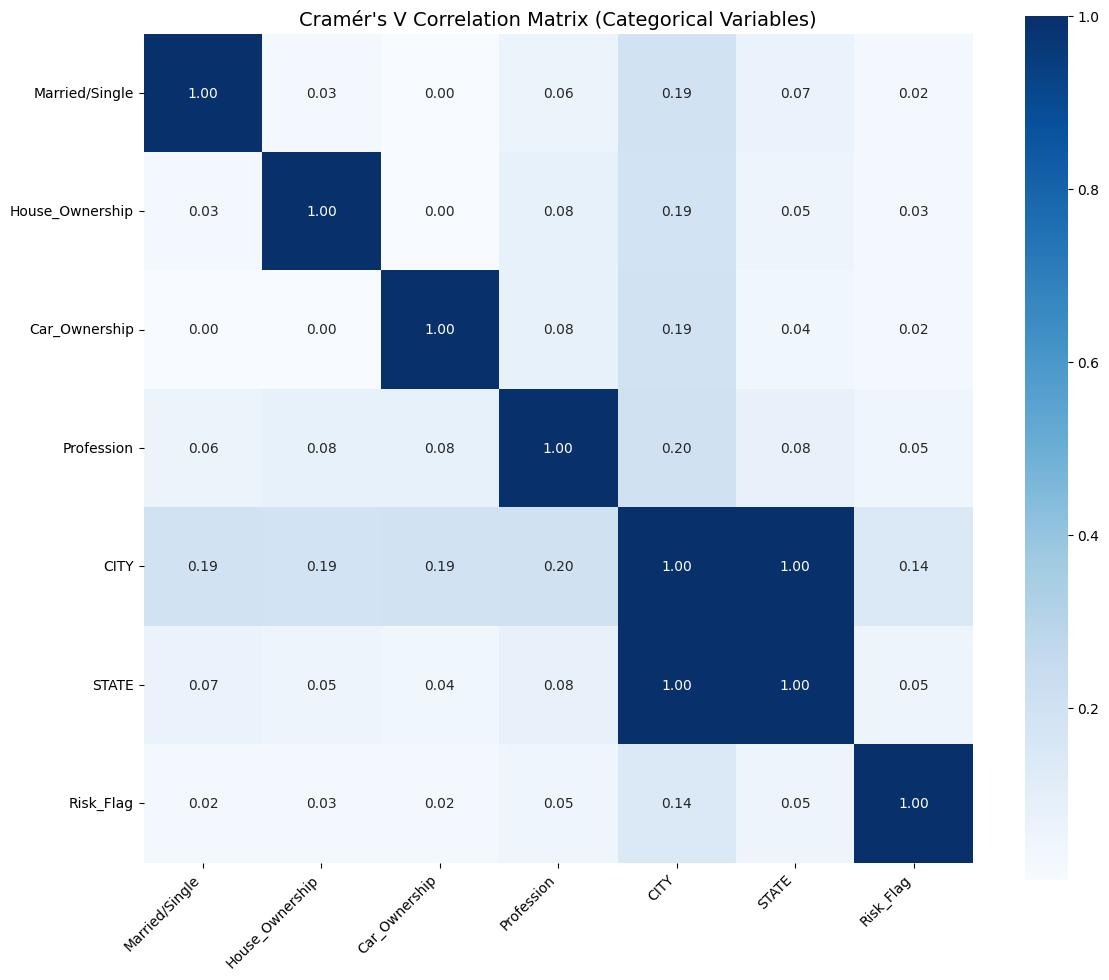

In [25]:
# Function to calculate Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# Select categorical columns for analysis (excluding Id)
cat_cols = ['Married/Single', 'House_Ownership', 'Car_Ownership',
            'Profession', 'CITY', 'STATE', 'Risk_Flag']

# Compute Cramér's V matrix
cramers_results = pd.DataFrame(index=cat_cols, columns=cat_cols)

for col1 in cat_cols:
    for col2 in cat_cols:
        cramers_results.loc[col1, col2] = cramers_v(train_df[col1], train_df[col2])

# Convert to float for heatmap
cramers_results = cramers_results.astype(float)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cramers_results, annot=True, cmap="Blues", fmt=".2f", square=True)
plt.title("Cramér's V Correlation Matrix (Categorical Variables)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [26]:
# Function to compute Cramer's V statistics
def cramers_v(x, y):
    """Compute Cramér’s V statistic for categorical-categorical association."""
    confusion_matrix = pd.crosstab(x, y)
    if confusion_matrix.shape[0] == 1 or confusion_matrix.shape[1] == 1:
        return np.nan  # Avoid divide-by-zero
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# function to show correlation matrices
def correlation_matrices(df, target='Risk_Flag'):
    # Separate numeric and categorical
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop(target, errors='ignore')
    cat_cols = df.select_dtypes(include=['object', 'category']).columns

    print("🔵 Pearson Correlation Matrix (Numerical Variables):")
    corr_numeric = df[numeric_cols].corr(method='pearson')
    display(corr_numeric)

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_numeric, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Numeric Variable Correlation (Pearson)")
    plt.show()

    print("\n🔴 Cramér’s V Correlation Matrix (Categorical Variables):")
    cramers_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)

    for col1 in cat_cols:
        for col2 in cat_cols:
            cramers_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

    display(cramers_matrix)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cramers_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Categorical Variable Correlation (Cramér’s V)")
    plt.show()

    print("\n📊 Correlation with target variable:", target)

    # Correlation with target
    for col in numeric_cols:
        corr = df[col].corr(df[target])
        print(f"{col} vs {target} (Pearson): {corr:.3f}")

    for col in cat_cols:
        corr = cramers_v(df[col], df[target])
        print(f"{col} vs {target} (Cramér’s V): {corr:.3f}")


🔵 Pearson Correlation Matrix (Numerical Variables):


,Id,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS
Id,1.000000,-0.002382,0.004843,-0.001999,0.000083,-0.001527
Income,-0.002382,1.000000,-0.001013,0.006701,0.007301,-0.003105
Age,0.004843,-0.001013,1.000000,-0.000813,0.001899,-0.019621
Experience,-0.001999,0.006701,-0.000813,1.000000,0.645206,0.019609
CURRENT_JOB_YRS,0.000083,0.007301,0.001899,0.645206,1.000000,0.005545
CURRENT_HOUSE_YRS,-0.001527,-0.003105,-0.019621,0.019609,0.005545,1.000000


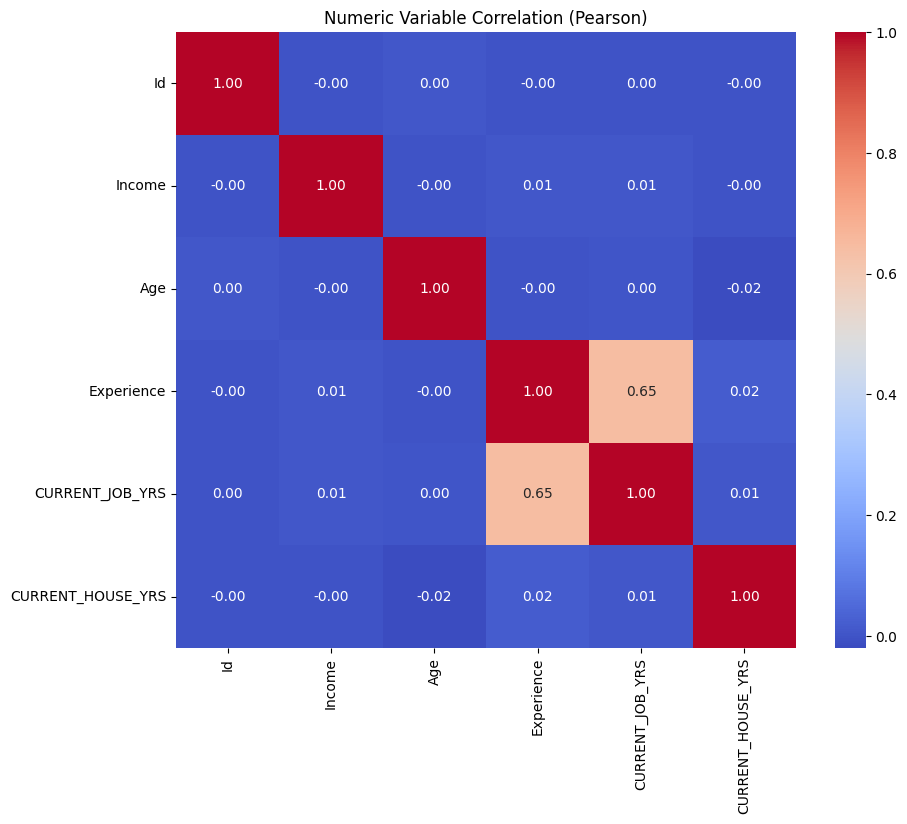


🔴 Cramér’s V Correlation Matrix (Categorical Variables):


,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,Age_Group,Income_Band,Age_Group_Str,Income_Band_Str
Married/Single,0.999977,0.026216,0.000816,0.059469,0.193436,0.066857,0.014075,0.020246,0.014075,0.020246
House_Ownership,0.026216,1.000000,0.002612,0.079621,0.188600,0.051635,0.017563,0.024738,0.017563,0.024738
Car_Ownership,0.000816,0.002612,0.999990,0.080495,0.193620,0.043328,0.026851,0.010233,0.026851,0.010233
Profession,0.059469,0.079621,0.080495,1.000000,0.196138,0.078243,0.076566,0.076685,0.076566,0.076685
CITY,0.193436,0.188600,0.193620,0.196138,1.000000,1.000000,0.200241,0.201125,0.200241,0.201125
STATE,0.066857,0.051635,0.043328,0.078243,1.000000,1.000000,0.059438,0.055789,0.059438,0.055789
Age_Group,0.014075,0.017563,0.026851,0.076566,0.200241,0.059438,1.000000,0.024900,1.000000,0.024900
Income_Band,0.020246,0.024738,0.010233,0.076685,0.201125,0.055789,0.024900,1.000000,0.024900,1.000000
Age_Group_Str,0.014075,0.017563,0.026851,0.076566,0.200241,0.059438,1.000000,0.024900,1.000000,0.024900
Income_Band_Str,0.020246,0.024738,0.010233,0.076685,0.201125,0.055789,0.024900,1.000000,0.024900,1.000000


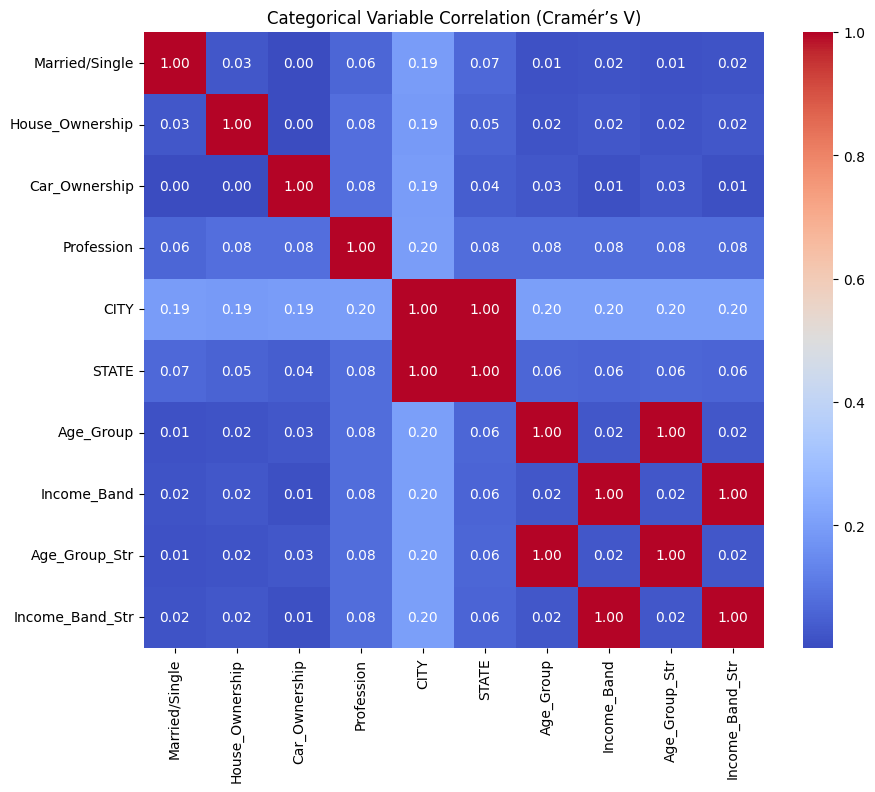


📊 Correlation with target variable: Risk_Flag
Id vs Risk_Flag (Pearson): 0.002
Income vs Risk_Flag (Pearson): -0.002
Age vs Risk_Flag (Pearson): -0.021
Experience vs Risk_Flag (Pearson): -0.034
CURRENT_JOB_YRS vs Risk_Flag (Pearson): -0.016
CURRENT_HOUSE_YRS vs Risk_Flag (Pearson): -0.005
Married/Single vs Risk_Flag (Cramér’s V): 0.022
House_Ownership vs Risk_Flag (Cramér’s V): 0.026
Car_Ownership vs Risk_Flag (Cramér’s V): 0.024
Profession vs Risk_Flag (Cramér’s V): 0.050
CITY vs Risk_Flag (Cramér’s V): 0.144
STATE vs Risk_Flag (Cramér’s V): 0.054
Age_Group vs Risk_Flag (Cramér’s V): 0.031
Income_Band vs Risk_Flag (Cramér’s V): 0.018
Age_Group_Str vs Risk_Flag (Cramér’s V): 0.031
Income_Band_Str vs Risk_Flag (Cramér’s V): 0.018


In [27]:
correlation_matrices(train_df, target='Risk_Flag')

## 1. Data Preprocessing

###Clean datasets

In [28]:
# Clean column names to remove invalid characters
def clean_column_names(obj):
    """
    Clean column names by removing special characters like [, ], <, >.
    Can handle both DataFrames and list/Index of column names.
    """
    if isinstance(obj, pd.DataFrame):
        obj.columns = pd.Index(obj.columns).str.replace(r'[\[\]<>]', '', regex=True)
        return obj
    elif isinstance(obj, (list, pd.Index)):
        return pd.Index(obj).str.replace(r'[\[\]<>]', '', regex=True)
    else:
        raise TypeError("Expected a DataFrame or list/Index of column names")

In [29]:
train_df = clean_column_names(train_df)
test_df = clean_column_names(test_df)

Drop unnecessary columns

In [30]:
# For train set
processed_train_df = train_df.drop(columns=['Id', 'CITY', 'Income_Band','Age_Group','Income_Band_Str', 'Age_Group_Str'], errors='ignore')

# For final test set (unlabeled)
processed_test_df = test_df.drop(columns=['Id', 'CITY'], errors='ignore')

Train/Validation Split

In [31]:
# Define target and features
X = processed_train_df.drop(columns='Risk_Flag')
y = processed_train_df['Risk_Flag']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

### Encoding categorical variables

In [32]:
# House ownership risk: owned < norent_noown < rented
# lower value = lower risk
house_map = {'owned': 0, 'norent_noown': 1, 'rented': 2}

# Car ownership: yes = 1 (less risky), no = 0
car_map = {'no': 0, 'yes': 1}

for df in [X_train, X_test, processed_test_df]:
    df['House_Ownership'] = df['House_Ownership'].map(house_map)
    df['Car_Ownership'] = df['Car_Ownership'].map(car_map)

#X_train['House_Ownership'] = X_train['House_Ownership'].map(house_map)
#X_test['House_Ownership'] = X_test['House_Ownership'].map(house_map)
#processed_test_df['House_Ownership'] = processed_test_df['House_Ownership'].map(house_map)

#X_train['Car_Ownership'] = X_train['Car_Ownership'].map(car_map)
#X_test['Car_Ownership'] = X_test['Car_Ownership'].map(car_map)
#processed_test_df['Car_Ownership'] = processed_test_df['Car_Ownership'].map(car_map)

In [33]:
# Frequency encode for "Profession"
prof_map = X_train['Profession'].value_counts(normalize=True).to_dict()

for df in [X_train, X_test, processed_test_df]:
    df['Profession_Freq'] = df['Profession'].map(prof_map)
    df.drop(columns='Profession', inplace=True)

'''
X_train['Profession_Freq'] = X_train['Profession'].map(prof_map)
X_test['Profession_Freq'] = X_test['Profession'].map(prof_map)
processed_test_df['Profession_Freq'] = processed_test_df['Profession'].map(prof_map)

X_train.drop(columns='Profession', inplace=True)
X_test.drop(columns='Profession', inplace=True)
processed_test_df.drop(columns='Profession', inplace=True)
'''

"\nX_train['Profession_Freq'] = X_train['Profession'].map(prof_map)\nX_test['Profession_Freq'] = X_test['Profession'].map(prof_map)\nprocessed_test_df['Profession_Freq'] = processed_test_df['Profession'].map(prof_map)\n\nX_train.drop(columns='Profession', inplace=True)\nX_test.drop(columns='Profession', inplace=True)\nprocessed_test_df.drop(columns='Profession', inplace=True)\n"

In [34]:
# One-hot encoding for Married/Single and STATE
nominal_cols = ['Married/Single', 'STATE']
ohe = ColumnTransformer(
    transformers=[
        ('nom', OneHotEncoder(handle_unknown='ignore', sparse_output=False), nominal_cols)
    ],
    remainder='passthrough'
)

X_train_encoded = ohe.fit_transform(X_train)  # train set
X_test_encoded = ohe.transform(X_test) # validation set
X_final_test = ohe.transform(processed_test_df) # for unseen test set with no label

ohe_features = ohe.named_transformers_['nom'].get_feature_names_out(nominal_cols)
other_cols = [col for col in X_train.columns if col not in nominal_cols]
final_feature_names = list(ohe_features) + other_cols

In [35]:
# Clean final feature names and build encoded DataFrames
cleaned_feature_names = clean_column_names(final_feature_names)

X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=cleaned_feature_names)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=cleaned_feature_names)
X_final_test_df = pd.DataFrame(X_final_test, columns=cleaned_feature_names)

## 2. Model Training

###Evaluation functions

In [36]:
# Define an evaluation function
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name='Model', threshold=0.5, cost_fn=10, cost_fp=1):
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    cost = fn * cost_fn + fp * cost_fp
    train_f1 = f1_score(y_train, model.predict(X_train))
    test_f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_proba)

    print(f"\n=== {model_name} Evaluation ===")
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC Score: {auc_score:.4f}")
    print(f"Train F1 Score: {train_f1:.4f}")
    print(f"Test F1 Score (threshold={threshold}): {test_f1:.4f}")
    print(f"Cost (FN={cost_fn}, FP={cost_fp}): {cost}")

    return {
        'Model': model_name,
        'Train F1': train_f1,
        'Test F1': test_f1,
        'ROC AUC': auc_score,
        'Cost': cost,
        'Threshold': threshold
    }

In [37]:
# Plot ROC curve
def plot_roc_curve(model, X_test, y_test, label='Model'):
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {label}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


In [38]:
# Threshold tuning for F1
def tune_threshold_for_f1(model, X_test, y_test, model_name='Model', cost_fn=10, cost_fp=1):
    print(f"\n--- Threshold Tuning for {model_name} (F1 Focus) ---")
    best_threshold = 0.5
    best_f1 = 0
    thresholds = [round(t, 2) for t in list(np.arange(0.3, 0.61, 0.01))]

    for t in thresholds:
        y_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= t).astype(int)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        cost = fn * cost_fn + fp * cost_fp
        #print(f"Threshold: {t}, F1: {f1:.4f}, Cost: {cost}")

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t

    print(f"Selected Threshold: {best_threshold}, F1 Score: {best_f1:.4f}")
    return best_threshold

#### Train models

In [39]:
X_train_lr = X_train_encoded_df.drop(columns=['CURRENT_JOB_YRS'], errors='ignore')
X_test_lr = X_test_encoded_df.drop(columns=['CURRENT_JOB_YRS'], errors='ignore')

In [40]:
models = {
    'LogReg Native': (LogisticRegression(max_iter=1000, random_state=42), X_train_lr, X_test_lr),
    'RF Native': (RandomForestClassifier(n_estimators=100, random_state=42), X_train_encoded_df, X_test_encoded_df),
    'XGB Native': (XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), X_train_encoded_df, X_test_encoded_df),
    'LogReg Weighted': (LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42), X_train_lr, X_test_lr),
    'RF Weighted': (RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42), X_train_encoded_df, X_test_encoded_df),
    'XGB Weighted': (XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(), use_label_encoder=False, eval_metric='logloss', random_state=42), X_train_encoded_df, X_test_encoded_df)
}

In [41]:
all_results = []

for name, (model, X_tr, X_te) in models.items():
    print(f"\nTraining: {name}")
    model.fit(X_tr, y_train)
    threshold = tune_threshold_for_f1(model, X_te, y_test, model_name=name)
    results = evaluate_model(model, X_tr, X_te, y_train, y_test, model_name=name, threshold=threshold)
    all_results.append(results)


Training: LogReg Native

--- Threshold Tuning for LogReg Native (F1 Focus) ---
Selected Threshold: 0.5, F1 Score: 0.0000

=== LogReg Native Evaluation ===
Confusion Matrix:
[[61048     0]
 [ 8552     0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     61048
           1       0.00      0.00      0.00      8552

    accuracy                           0.88     69600
   macro avg       0.44      0.50      0.47     69600
weighted avg       0.77      0.88      0.82     69600

ROC AUC Score: 0.5267
Train F1 Score: 0.0000
Test F1 Score (threshold=0.5): 0.0000
Cost (FN=10, FP=1): 85520

Training: RF Native

--- Threshold Tuning for RF Native (F1 Focus) ---
Selected Threshold: 0.32, F1 Score: 0.6366

=== RF Native Evaluation ===
Confusion Matrix:
[[55907  5141]
 [ 2158  6394]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94     61048
        

In [42]:
results_df = pd.DataFrame(all_results)
print("\n=== Summary of All Model Results ===")
print(results_df.sort_values(by='Test F1', ascending=False))


=== Summary of All Model Results ===
             Model  Train F1   Test F1   ROC AUC   Cost  Threshold
4      RF Weighted  0.767139  0.646375  0.938440  25509       0.60
1        RF Native  0.758898  0.636631  0.937800  26721       0.32
5     XGB Weighted  0.600297  0.595367  0.877157  29840       0.59
2       XGB Native  0.342098  0.546978  0.876795  44135       0.30
3  LogReg Weighted  0.174036  0.219138  0.515538  61277       0.48
0    LogReg Native  0.000000  0.000000  0.526719  85520       0.50


### Modeling with SMOTE+Tomek and SMOTE+ENN
Since the logistic regression model shows extremely high cost, low recall and low f1-score for predicting positive class (i.e. Risk_Flag = 1), we choose to proceed the resampling and tuning steps with random forest and XGBoost models only.

Threshold tuning to find threshold with lowest cost.

Resampling using SMOTE+Tomek and SMOTE+ENN.

In [43]:
# Define resampling strategies
resampling_strategies = {
    'SMOTE': SMOTE(random_state=42),
    'SMOTE+Tomek': SMOTETomek(random_state=42),
    'SMOTE+ENN': SMOTEENN(random_state=42)
}

In [44]:
# Loop over each resampling method and model
for method_name, sampler in resampling_strategies.items():
    print(f"\n--- Training RandomForest with {method_name} ---")
    X_resampled, y_resampled = sampler.fit_resample(X_train_encoded_df, y_train)

    rf_resampled = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_resampled.fit(X_resampled, y_resampled)

    threshold_rf = tune_threshold_for_f1(rf_resampled, X_test_encoded_df, y_test, model_name=f'RF {method_name}')
    results_rf = evaluate_model(
        rf_resampled, X_resampled, X_test_encoded_df, y_resampled, y_test,
        model_name=f'RF {method_name}', threshold=threshold_rf
    )
    all_results.append(results_rf)

    print(f"\n--- Training XGBoost with {method_name} ---")
    xgb_resampled = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb_resampled.fit(X_resampled, y_resampled)

    threshold_xgb = tune_threshold_for_f1(xgb_resampled, X_test_encoded_df, y_test, model_name=f'XGB {method_name}')
    results_xgb = evaluate_model(
        xgb_resampled, X_resampled, X_test_encoded_df, y_resampled, y_test,
        model_name=f'XGB {method_name}', threshold=threshold_xgb
    )
    all_results.append(results_xgb)


--- Training RandomForest with SMOTE ---

--- Threshold Tuning for RF SMOTE (F1 Focus) ---
Selected Threshold: 0.57, F1 Score: 0.6463

=== RF SMOTE Evaluation ===
Confusion Matrix:
[[55960  5088]
 [ 2040  6512]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94     61048
           1       0.56      0.76      0.65      8552

    accuracy                           0.90     69600
   macro avg       0.76      0.84      0.79     69600
weighted avg       0.92      0.90      0.90     69600

ROC AUC Score: 0.9383
Train F1 Score: 0.9593
Test F1 Score (threshold=0.57): 0.6463
Cost (FN=10, FP=1): 25488

--- Training XGBoost with SMOTE ---

--- Threshold Tuning for XGB SMOTE (F1 Focus) ---
Selected Threshold: 0.57, F1 Score: 0.5911

=== XGB SMOTE Evaluation ===
Confusion Matrix:
[[56215  4833]
 [ 2936  5616]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92    

####Summary of all models (from native to resampling)

In [45]:
# Combine all results into a DataFrame
results_df = pd.DataFrame(all_results)

# Format float columns
results_df[['Train F1', 'Test F1', 'ROC AUC']] = results_df[['Train F1', 'Test F1', 'ROC AUC']].round(4)

# Add overfitting indicator (gap between Train and Test F1)
results_df['F1 Gap'] = (results_df['Train F1'] - results_df['Test F1']).round(4)

# Sort by Test F1
summary = results_df.sort_values(by='Test F1', ascending=False)

# Display nicely
print("\n=== Final Model Performance Summary ===")
print(summary[['Model', 'Train F1', 'Test F1', 'F1 Gap', 'ROC AUC', 'Cost', 'Threshold']])



=== Final Model Performance Summary ===
              Model  Train F1  Test F1  F1 Gap  ROC AUC   Cost  Threshold
4       RF Weighted    0.7671   0.6464  0.1207   0.9384  25509       0.60
6          RF SMOTE    0.9593   0.6463  0.3130   0.9383  25488       0.57
8    RF SMOTE+Tomek    0.9580   0.6462  0.3118   0.9380  25474       0.58
1         RF Native    0.7589   0.6366  0.1223   0.9378  26721       0.32
5      XGB Weighted    0.6003   0.5954  0.0049   0.8772  29840       0.59
7         XGB SMOTE    0.9122   0.5911  0.3211   0.8605  34193       0.57
9   XGB SMOTE+Tomek    0.9087   0.5846  0.3241   0.8609  31995       0.54
2        XGB Native    0.3421   0.5470 -0.2049   0.8768  44135       0.30
10     RF SMOTE+ENN    1.0000   0.3624  0.6376   0.8761  63708       0.30
11    XGB SMOTE+ENN    0.9719   0.2992  0.6727   0.6523  69317       0.30
3   LogReg Weighted    0.1740   0.2191 -0.0451   0.5155  61277       0.48
0     LogReg Native    0.0000   0.0000  0.0000   0.5267  85520       0.

For hyperparameter tuning, we choose the Random forest model with balanced weighted applied due to its high test F1, low difference between train F1 and test F1, and low cost compared to other models.

## Hyperparameters tuning

Tuning for Random Forest with weighted = balanced

In [46]:
# Define param grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': np.arange(1,6),
    'max_features': ['auto','sqrt', 'log2'],
    'criterion': ['gini', 'entropy','log_loss'],
    'class_weight': ['balanced']  # fixed for cost sensitivity
}

# Initialize model
rf_weighted = RandomForestClassifier(random_state=42)

# Randomized search setup
random_search = RandomizedSearchCV(
    estimator=rf_weighted,
    param_distributions=param_grid,
    n_iter=30,
    cv=3,
    verbose=1,
    n_jobs=-1,
    scoring='f1',
    random_state=42
)

In [47]:
# Run search
random_search.fit(X_train_encoded_df, y_train)
best_rf = random_search.best_estimator_

# Show best hyperparameters
print("\n=== Best Hyperparameters ===")
for k, v in random_search.best_params_.items():
    print(f"{k}: {v}")

Fitting 3 folds for each of 30 candidates, totalling 90 fits

=== Best Hyperparameters ===
n_estimators: 300
min_samples_split: 5
min_samples_leaf: 2
max_features: log2
max_depth: None
criterion: log_loss
class_weight: balanced


In [48]:
# Threshold tuning using F1
best_thresh = tune_threshold_for_f1(best_rf, X_test_encoded_df, y_test, model_name='Tuned RF Weighted')

# Final evaluation
best_rf_results = evaluate_model(
    best_rf, X_train_encoded_df, X_test_encoded_df, y_train, y_test,
    model_name='Tuned RF Weighted', threshold=best_thresh
)

# Append result
all_results.append(best_rf_results)


--- Threshold Tuning for Tuned RF Weighted (F1 Focus) ---
Selected Threshold: 0.59, F1 Score: 0.6464

=== Tuned RF Weighted Evaluation ===
Confusion Matrix:
[[55958  5090]
 [ 2038  6514]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94     61048
           1       0.56      0.76      0.65      8552

    accuracy                           0.90     69600
   macro avg       0.76      0.84      0.79     69600
weighted avg       0.92      0.90      0.90     69600

ROC AUC Score: 0.9380
Train F1 Score: 0.7615
Test F1 Score (threshold=0.59): 0.6464
Cost (FN=10, FP=1): 25470


## Prediction on unseen test data

In [49]:
# Make predictions on unseen test data
final_probs = best_rf.predict_proba(X_final_test_df)[:, 1]
final_preds = (final_probs >= best_thresh).astype(int)

# Build submission
final_submission = pd.DataFrame({
    'Id': test_df['Id'],   # from original unprocessed test_df
    'Risk_Flag': final_preds
})

# Save it
final_submission.to_csv('final_predictions.csv', index=False)


In [50]:
from google.colab import files
files.download('final_predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Explain model with SHAP

In [56]:
import shap

In [57]:
# Sample from encoded training set
sample_X = X_train_encoded_df.sample(n=1000, random_state=42)

# Use best trained model
explainer = shap.TreeExplainer(best_rf)

# Get SHAP values
# This returns an array of shape (n_samples, n_features, n_classes)
shap_values = explainer.shap_values(sample_X)

# Ensure column names are string as required by some SHAP plotting functions
sample_X.columns = sample_X.columns.astype(str)


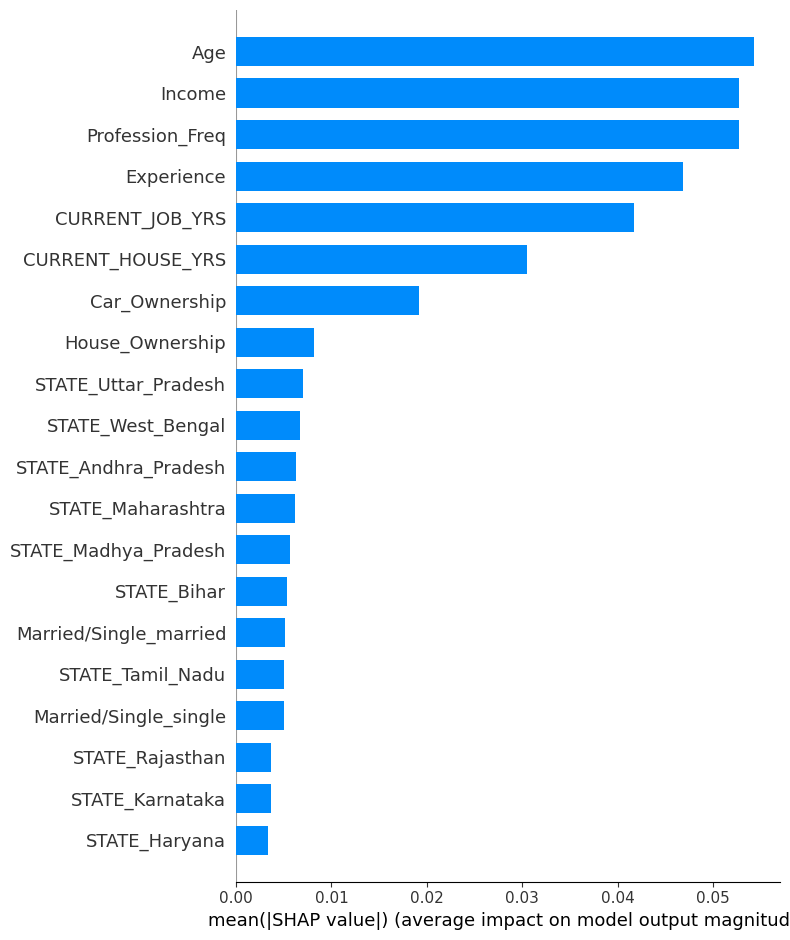

In [58]:
# Plot the summary for the positive class (Risk_Flag=1), which is at index 1
# We need to slice the shap_values array to get the values for class 1 across all samples and features
# The shape of shap_values is (n_samples, n_features, n_classes)
# We want shap_values[:, :, 1] which will have shape (n_samples, n_features)
shap.summary_plot(shap_values[:, :, 1], sample_X, plot_type="bar")

**Insight**:


SHAP plot show that age, income, experience and types of ownerships and some states like Uttar Pradesh and West Bengal are important in predicting the credit risk.

To improve the model's performance, we can select some of the representative states to include in the input features, and set the other less relevant states as "Other" to reduce the number of unique values to speed up the computation and result in a better prediction if they are not significant in classifying the customers.